## 1. define adopter user and data preprocessing for modeling

In [1]:
#read data into the system
import pandas as pd
f1='takehome_user_engagement.csv'
f2='takehome_users.csv'
df1=pd.read_csv(f1)
df2=pd.read_csv(f2)

In [2]:
#Defining an "adopted user" as a user who has logged into the product on three separate days in at least one sevenday period
df1.head()

,time_stamp,user_id,visited
0,2014-04-22 03:53:30,1,1
1,2013-11-15 03:45:04,2,1
2,2013-11-29 03:45:04,2,1
3,2013-12-09 03:45:04,2,1
4,2013-12-25 03:45:04,2,1


In [3]:
import datetime
df1.time_stamp.max()

'2014-06-06 14:58:50'

In [4]:
df1.dtypes

time_stamp    object
user_id        int64
visited        int64
dtype: object

In [5]:
df1_n=df1.copy()
df1_n['time']=pd.to_datetime(df1_n.time_stamp)
df1_n.drop(columns=['time_stamp'], inplace=True)

In [6]:
gr=df1_n[df1_n.user_id==2]
gr.set_index('time', inplace=True)

In [7]:
gr.asfreq('D')

,user_id,visited
time,,
2013-11-15 03:45:04,2.0,1.0
2013-11-16 03:45:04,NaN,NaN
2013-11-17 03:45:04,NaN,NaN
2013-11-18 03:45:04,NaN,NaN
2013-11-19 03:45:04,NaN,NaN
...,...,...
2014-03-27 03:45:04,NaN,NaN
2014-03-28 03:45:04,NaN,NaN
2014-03-29 03:45:04,NaN,NaN


In [8]:
df1_n.user_id.unique()

array([    1,     2,     3, ..., 11998, 11999, 12000], dtype=int64)

In [9]:
#fill in blank data
#data split into group based on user_id
#fill in blank data and make sure there is daily data on every day.
user_id=df1_n.user_id.unique()
def user_id_group(id):
    d=df1_n[df1_n.user_id==id]
    return d
def fill_blank_d(df):
    df.set_index('time', inplace=True)
    return df.asfreq('D')
def fill_blank_other(df):
    df.user_id.fillna(method='ffill', inplace=True)
    df.visited.fillna(0, inplace=True)
    return df

In [10]:
group=[user_id_group(id) for id in user_id]
complete_d=[fill_blank_d(df) for df in group]

In [11]:
complete_fill=[fill_blank_other(df) for df in complete_d]

In [12]:
type(complete_fill[1])

pandas.core.frame.DataFrame

In [13]:
complete_fill[1]

,user_id,visited
time,,
2013-11-15 03:45:04,2.0,1.0
2013-11-16 03:45:04,2.0,0.0
2013-11-17 03:45:04,2.0,0.0
2013-11-18 03:45:04,2.0,0.0
2013-11-19 03:45:04,2.0,0.0
...,...,...
2014-03-27 03:45:04,2.0,0.0
2014-03-28 03:45:04,2.0,0.0
2014-03-29 03:45:04,2.0,0.0


In [14]:
n_range=len(complete_fill)

In [15]:
#convert nested list into pandas dataframe and use rolling
complete_date=pd.concat([complete_fill[i] for i in range(n_range)])

In [16]:
complete_date=complete_date.reset_index()
complete_date.head()

,time,user_id,visited
0,2014-04-22 03:53:30,1.0,1.0
1,2013-11-15 03:45:04,2.0,1.0
2,2013-11-16 03:45:04,2.0,0.0
3,2013-11-17 03:45:04,2.0,0.0
4,2013-11-18 03:45:04,2.0,0.0


In [17]:
#rolling
seven_d_visit=complete_date.groupby('user_id').rolling(7, on='time').visited.sum()

In [18]:
seven_d_f=pd.DataFrame(seven_d_visit).rename(columns={'visited':'count_7d'})

In [19]:
df1_n_7=pd.merge(df1_n, seven_d_f, on=['time', 'user_id'], how='left')

In [20]:
adopted_user=df1_n_7.loc[(df1_n_7.count_7d >=3)]
adopted_user_unique=adopted_user.user_id.unique()
#then we successfully identified the adopted users in our data

In [21]:
len(adopted_user_unique)

1580

In [22]:
df2.head()

,object_id,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id
0,1,2014-04-22 03:53:30,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,1.398139e+09,1,0,11,10803.0
1,2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,1.396238e+09,0,0,1,316.0
2,3,2013-03-19 23:14:52,Bottrill Mitchell,MitchellBottrill@gustr.com,ORG_INVITE,1.363735e+09,0,0,94,1525.0
3,4,2013-05-21 08:09:28,Clausen Nicklas,NicklasSClausen@yahoo.com,GUEST_INVITE,1.369210e+09,0,0,1,5151.0
4,5,2013-01-17 10:14:20,Raw Grace,GraceRaw@yahoo.com,GUEST_INVITE,1.358850e+09,0,0,193,5240.0


In [23]:
df2['adopted_user']=df2['object_id'].apply(lambda x: 1 if x in adopted_user_unique else 0)
#label the data, 1 for adopted user, o for non-adopted user

In [24]:
df2.head()

,object_id,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id,adopted_user
0,1,2014-04-22 03:53:30,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,1.398139e+09,1,0,11,10803.0,0
1,2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,1.396238e+09,0,0,1,316.0,1
2,3,2013-03-19 23:14:52,Bottrill Mitchell,MitchellBottrill@gustr.com,ORG_INVITE,1.363735e+09,0,0,94,1525.0,0
3,4,2013-05-21 08:09:28,Clausen Nicklas,NicklasSClausen@yahoo.com,GUEST_INVITE,1.369210e+09,0,0,1,5151.0,0
4,5,2013-01-17 10:14:20,Raw Grace,GraceRaw@yahoo.com,GUEST_INVITE,1.358850e+09,0,0,193,5240.0,0


In [25]:
#define invited_by_user_or_not, na is 0, else is 1
df2['invited_by_user_or_not']=df2['invited_by_user_id'].apply(lambda x: 1 if x is not None else 0)

In [26]:
df2.drop(columns=['invited_by_user_id'], inplace=True)

In [27]:
df2.head()

,object_id,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,adopted_user,invited_by_user_or_not
0,1,2014-04-22 03:53:30,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,1.398139e+09,1,0,11,0,1
1,2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,1.396238e+09,0,0,1,1,1
2,3,2013-03-19 23:14:52,Bottrill Mitchell,MitchellBottrill@gustr.com,ORG_INVITE,1.363735e+09,0,0,94,0,1
3,4,2013-05-21 08:09:28,Clausen Nicklas,NicklasSClausen@yahoo.com,GUEST_INVITE,1.369210e+09,0,0,1,0,1
4,5,2013-01-17 10:14:20,Raw Grace,GraceRaw@yahoo.com,GUEST_INVITE,1.358850e+09,0,0,193,0,1


## 2. data pre-processing

In [28]:
df2.dtypes

object_id                       int64
creation_time                  object
name                           object
email                          object
creation_source                object
last_session_creation_time    float64
opted_in_to_mailing_list        int64
enabled_for_marketing_drip      int64
org_id                          int64
adopted_user                    int64
invited_by_user_or_not          int64
dtype: object

In [29]:
#name, creation_time, email 
# difference between creation_time and last_session_creation_time
import time
df2['creat_time']=pd.to_datetime(df2.creation_time)

In [30]:
df2['creation_time_unix']=df2['creat_time'].apply(lambda x: time.mktime(x.timetuple()))

In [31]:
df2.drop(columns=['creation_time'], inplace=True)
df2.dtypes

object_id                              int64
name                                  object
email                                 object
creation_source                       object
last_session_creation_time           float64
opted_in_to_mailing_list               int64
enabled_for_marketing_drip             int64
org_id                                 int64
adopted_user                           int64
invited_by_user_or_not                 int64
creat_time                    datetime64[ns]
creation_time_unix                   float64
dtype: object

In [32]:
df2.creation_source.value_counts()
#convert creation_source into dummy variables

ORG_INVITE            4254
GUEST_INVITE          2163
PERSONAL_PROJECTS     2111
SIGNUP                2087
SIGNUP_GOOGLE_AUTH    1385
Name: creation_source, dtype: int64

In [33]:
from sklearn import preprocessing
le = preprocessing.LabelEncoder()
df2['creation_source_c']=le.fit_transform(df2.creation_source)

In [34]:
df2.drop(columns=['creation_source', 'creat_time'], inplace=True)
df2.dtypes

object_id                       int64
name                           object
email                          object
last_session_creation_time    float64
opted_in_to_mailing_list        int64
enabled_for_marketing_drip      int64
org_id                          int64
adopted_user                    int64
invited_by_user_or_not          int64
creation_time_unix            float64
creation_source_c               int32
dtype: object

In [35]:
df2_model=df2.drop(columns=['email', 'name'])
df2_model.isnull().sum()

object_id                        0
last_session_creation_time    3177
opted_in_to_mailing_list         0
enabled_for_marketing_drip       0
org_id                           0
adopted_user                     0
invited_by_user_or_not           0
creation_time_unix               0
creation_source_c                0
dtype: int64

In [36]:
#remove the obs with missing last_session_creation_time
df2_model.dropna(how = 'any', inplace=True)
df2_model.isnull().sum()

object_id                     0
last_session_creation_time    0
opted_in_to_mailing_list      0
enabled_for_marketing_drip    0
org_id                        0
adopted_user                  0
invited_by_user_or_not        0
creation_time_unix            0
creation_source_c             0
dtype: int64

In [37]:
df2_model.adopted_user.value_counts()

0    7243
1    1580
Name: adopted_user, dtype: int64

In [38]:
X=df2_model.drop(columns=['adopted_user', 'object_id'])
y=df2_model.adopted_user

## 3. modeling and find the important features

In [39]:
#data preprocessing for modeling
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, cross_validate
from sklearn.metrics import classification_report, roc_curve, roc_auc_score, confusion_matrix, accuracy_score, precision_score, recall_score
from sklearn.model_selection import RandomizedSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
X_train, X_test, y_train, y_test=train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)
st_scaler=StandardScaler()
X_train_s=st_scaler.fit_transform(X_train)
X_test_s=st_scaler.transform(X_test)

In [40]:
#we will try logistic regression to find the important factors
logreg = LogisticRegression()
param_grid = {'C': [0.1, 0.5, 1, 5, 10, 50, 100, 500, 1000, 5000, 10000]} # C is the inverse of regularization strength; must be a positive float. Smaller values of C mean stronger regularization.
logreg_cv = RandomizedSearchCV(logreg, param_grid , cv=5, random_state=42)
logreg_cv.fit(X_train_s,y_train)
print("BEST PARAMS", logreg_cv.best_params_)

BEST PARAMS {'C': 50}


In [41]:
import numpy as np
features_name=X.columns
from sklearn.feature_selection import SelectFromModel
best_C_logreg=logreg_cv.best_estimator_
sfm=SelectFromModel(best_C_logreg, threshold=-np.inf, max_features=3)
sfm.fit(X_train_s, y_train)
feature_idx=sfm.get_support()
feature_name=features_name[feature_idx]
feature_name

Index(['last_session_creation_time', 'creation_time_unix',
       'creation_source_c'],
      dtype='object')

The important features are 'last_session_creation_time' and 'creation_time_unix'.

Text(0.5, 15.0, 'Predicted label')

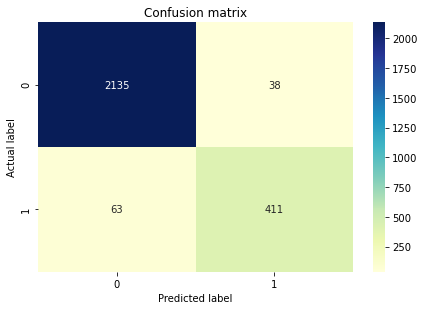

In [42]:
import seaborn as sns
import matplotlib.pyplot as plt
y_pred=best_C_logreg.predict(X_test_s)
cnf_matrix = confusion_matrix(y_test, y_pred)
sns.heatmap(pd.DataFrame(cnf_matrix), annot=True, cmap="YlGnBu" ,fmt='g')
plt.tight_layout()
plt.title('Confusion matrix')
plt.ylabel('Actual label')
plt.xlabel('Predicted label')

In [43]:
print("Accuracy:",accuracy_score(y_test, y_pred).round(3))
print("Precision:",precision_score(y_test, y_pred).round(3))
print("Recall:",recall_score(y_test, y_pred).round(3))

Accuracy: 0.962
Precision: 0.915
Recall: 0.867


In [44]:
#How about random forest, can it give us the same conclusion?
n_estimators=[int(x) for x in np.linspace(start = 50, stop = 500, num = 10)]
max_depths=[int(x) for x in np.linspace(1, 10, num = 10)]
param_grid = {'n_estimators': n_estimators, 'max_depth':max_depths}
rf = RandomForestClassifier()
rf_random = RandomizedSearchCV(estimator = rf, param_distributions=param_grid, cv = 5, verbose=2, random_state=42, n_jobs = -1)
rf_random.fit(X_train_s, y_train)
end=time.time()
print("BEST PARAMS", rf_random.best_params_)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
BEST PARAMS {'n_estimators': 200, 'max_depth': 9}


In [45]:
best_rf=rf_random.best_estimator_
fea_importance=dict(zip(features_name, np.round(best_rf.feature_importances_, 2)))
sort_fea_importance={}
sorted_keys = sorted(fea_importance, key=fea_importance.get)
for i in sorted_keys:
    sort_fea_importance[i]=fea_importance[i]
print(sort_fea_importance)

{'opted_in_to_mailing_list': 0.0, 'enabled_for_marketing_drip': 0.0, 'invited_by_user_or_not': 0.0, 'creation_source_c': 0.01, 'org_id': 0.04, 'creation_time_unix': 0.19, 'last_session_creation_time': 0.75}


Text(0.5, 15.0, 'Predicted label')

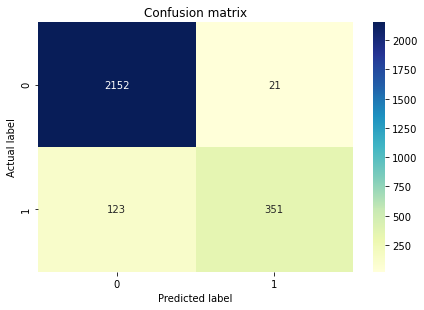

In [46]:
y_pred=best_rf.predict(X_test_s)
cnf_matrix = confusion_matrix(y_test, y_pred)
sns.heatmap(pd.DataFrame(cnf_matrix), annot=True, cmap="YlGnBu" ,fmt='g')
plt.tight_layout()
plt.title('Confusion matrix')
plt.ylabel('Actual label')
plt.xlabel('Predicted label')

In [47]:
print("Accuracy:",accuracy_score(y_test, y_pred).round(3))
print("Precision:",precision_score(y_test, y_pred).round(3))
print("Recall:",recall_score(y_test, y_pred).round(3))

Accuracy: 0.946
Precision: 0.944
Recall: 0.741


#### conclusion: 'creation_time_unix' and 'last_session_creation_time' are the most important features regardless which model we use.